# Setting Up


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import os
os.chdir("/content/gdrive/My Drive/COVID")
!pwd

/content/gdrive/My Drive/COVID


# Importing Libraries

In [117]:
from tensorflow.keras.models import Model , load_model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Importing Data


In [15]:
# setting important parameters/variables
data_dir = os.listdir("two/")
train_dir = "two/" + data_dir[0]
test_dir = "two/" + data_dir[1]
image_size = (150, 150)
Batch_size = 64

In [113]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_std_normalization = True,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = image_size,
                                               shuffle = True,
                                               batch_size = Batch_size,
                                               subset = "training",
                                               class_mode = "binary")

val_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = image_size,
                                               shuffle = True,
                                               batch_size = Batch_size,
                                               subset = "validation",
                                               class_mode = "binary")

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=image_size,
                                            batch_size=1,
                                            shuffle=True,
                                            class_mode="binary")
test_data.reset()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


# Setting Up Important Functions

In [100]:
def get_model(base_model_name):
  if base_model_name == "vgg16":
    base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
  elif base_model_name == "vgg19":
    base_model = VGG19(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
  elif base_model_name == "resnet50":
    base_model = ResNet50(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))

  base_model.trainable = False

  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(1, activation = "sigmoid"))

  

  return model

In [110]:
def plot_history(history, epochs):
  x = range(1, epochs)
  acc = history.history["acc"]
  val_acc = history.history["val_acc"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  plt.figure(figsize = (15, 5))
  plt.subplot(121)
  plt.plot(x, acc[1:], label = "Train_Acc")
  plt.plot(x, val_acc[1:], label = "Val_Acc")
  plt.title("Accuracy over " + str(epochs) + " Epochs", size = 15)
  plt.legend()
  plt.subplot(122)
  plt.plot(x, loss[1:], label = "Train_loss")
  plt.plot(x, val_loss[1:], label = "Val_loss")
  plt.title("Loss over " + str(epochs) + " Epochs", size = 15)
  plt.legend()
  plt.show()

In [121]:
def evaluate_model(model, test_data, plot_examples = True, no_of_examples = 5):
  test_data.reset()
  results = model.evaluate(test_data)

  print("Test Loss: ", results[0])
  print("Test Accuracy: ", results[1])

  if plot_examples:
    pred = model.predict(test_data)
    for index, probability in enumerate(pred):
        if index == no_of_examples:
          break
        image_path = test_dir + "/" + test_data.filenames[index]
        image = mpimg.imread(image_path)
        pixels = np.array(image)
        plt.imshow(pixels)        
        print("File: ", test_data.filenames[index])
        if probability > 0.5:
            plt.title("%.2f" % (probability[0]*100) + "% Normal")
        else:
            plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19")
        plt.show()

# Creating Models
## 1. VGG16 as Basemodel


In [135]:
model = get_model("vgg16")
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['acc'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_18 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [136]:
history = model.fit_generator(train_data, validation_data = val_data, epochs= 20)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
2/2 [==============================] - 16s 8s/step - loss: 0.9145 - acc: 0.5577 - val_loss: 0.7757 - val_acc: 0.5385
Epoch 2/20
2/2 [==============================] - 21s 10s/step - loss: 0.5395 - acc: 0.7885 - val_loss: 0.3852 - val_acc: 0.7692
Epoch 3/20
2/2 [==============================] - 15s 8s/step - loss: 0.4577 - acc: 0.7404 - val_loss: 0.1647 - val_acc: 1.0000
Epoch 4/20
2/2 [==============================] - 15s 8s/step - loss: 0.2111 - acc: 0.9423 - val_loss: 0.2103 - val_acc: 0.8846
Epoch 5/20
2/2 [==============================] - 15s 8s/step - loss: 0.1945 - acc: 0.9135 - val_loss: 0.1867 - val_acc: 0.8846
Epoch 6/20
2/2 [==============================] - 21s 10s/step - loss: 0.1398 - acc: 0.9519 - val_loss: 0.0614 - val_acc: 1.0000
Epoch 7/20
2/2 [==============================] - 16s 8s/step - loss: 0.0627 - acc: 0.9808 - val_loss: 0.0407 - val_acc: 1.0000
Epoch 8/20
2/2 [==============================] - 16s 8s/step - loss: 0.0693 - acc: 0.9712 - val_loss:

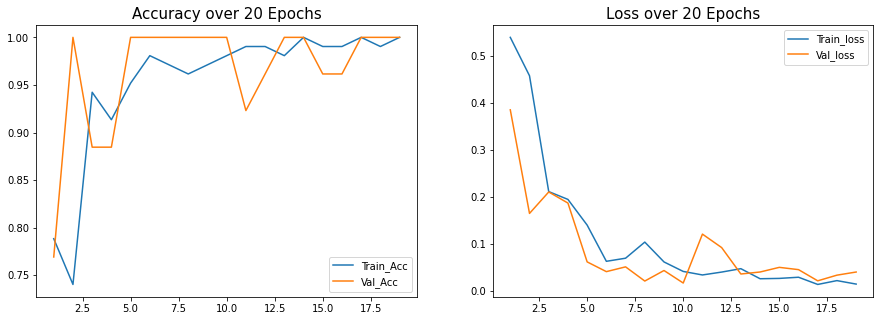

In [137]:
plot_history(history, 20)

18/18 [==============================] - 4s 247ms/step - loss: 0.0325 - acc: 1.0000
Test Loss:  0.032542821019887924
Test Accuracy:  1.0
File:  covid/nejmoa2001191_f3-PA.jpeg


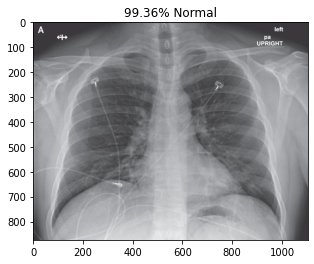

File:  covid/nejmoa2001191_f4.jpeg


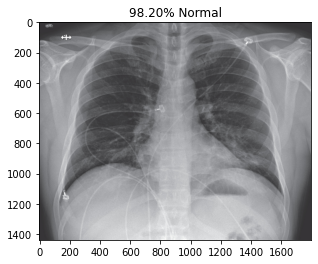

File:  covid/nejmoa2001191_f5-PA.jpeg


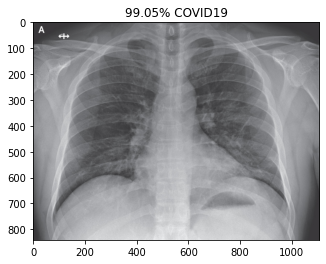

File:  covid/radiol.2020200490.fig3.jpeg


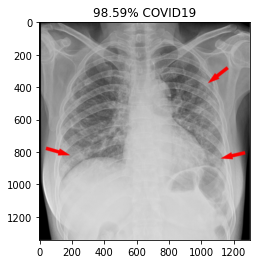

File:  covid/ryct.2020200028.fig1a.jpeg


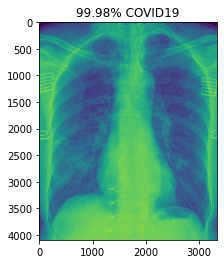

In [138]:
evaluate_model(model, test_data)

## 2. VGG19 as Basemodel



In [139]:
vgg19_model = get_model("vgg19")
vgg19_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['acc'])
vgg19_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_19 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


In [140]:
history_vgg19 = vgg19_model.fit_generator(train_data, validation_data = val_data, epochs= 20)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
2/2 [==============================] - 26s 13s/step - loss: 1.5061 - acc: 0.4808 - val_loss: 0.2715 - val_acc: 0.9615
Epoch 2/20
2/2 [==============================] - 26s 13s/step - loss: 0.8019 - acc: 0.6538 - val_loss: 0.8572 - val_acc: 0.5769
Epoch 3/20
2/2 [==============================] - 19s 10s/step - loss: 0.6736 - acc: 0.6346 - val_loss: 0.1090 - val_acc: 1.0000
Epoch 4/20
2/2 [==============================] - 26s 13s/step - loss: 0.1904 - acc: 0.9519 - val_loss: 0.2264 - val_acc: 0.9231
Epoch 5/20
2/2 [==============================] - 19s 10s/step - loss: 0.3577 - acc: 0.8269 - val_loss: 0.0910 - val_acc: 1.0000
Epoch 6/20
2/2 [==============================] - 26s 13s/step - loss: 0.1562 - acc: 0.9423 - val_loss: 0.0734 - val_acc: 0.9615
Epoch 7/20
2/2 [==============================] - 19s 10s/step - loss: 0.0960 - acc: 0.9712 - val_loss: 0.1219 - val_acc: 0.9615
Epoch 8/20
2/2 [==============================] - 26s 13s/step - loss: 0.1477 - acc: 0.9615 - val

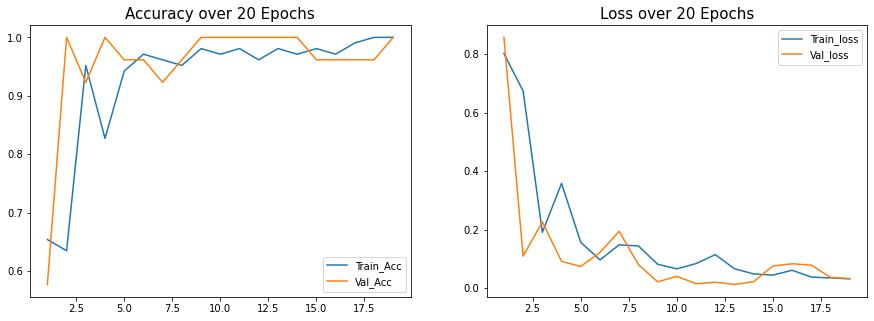

In [141]:
plot_history(history_vgg19, 20)

18/18 [==============================] - 6s 307ms/step - loss: 0.1087 - acc: 1.0000
Test Loss:  0.10867666453123093
Test Accuracy:  1.0
File:  covid/nejmoa2001191_f3-PA.jpeg


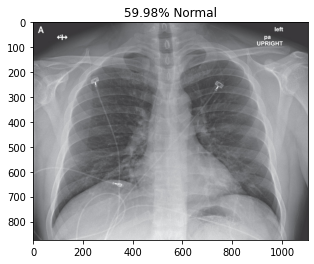

File:  covid/nejmoa2001191_f4.jpeg


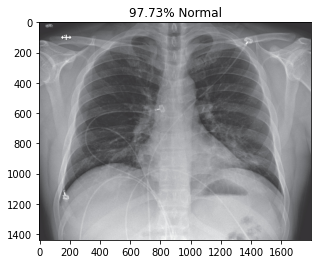

File:  covid/nejmoa2001191_f5-PA.jpeg


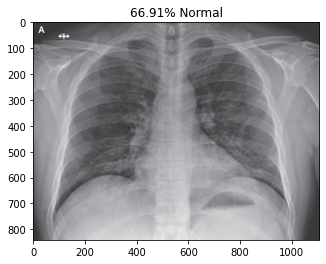

File:  covid/radiol.2020200490.fig3.jpeg


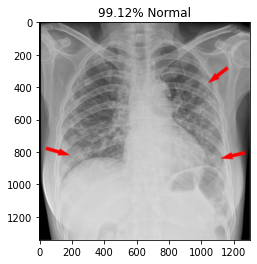

File:  covid/ryct.2020200028.fig1a.jpeg


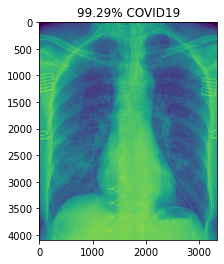

In [142]:
evaluate_model(vgg19_model, test_data)

## 3. Resnet50 as Basemodel

In [143]:
res_model = get_model("resnet50")
res_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['acc'])
res_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_20 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 257       
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________


In [144]:
history_res = res_model.fit_generator(train_data, validation_data = val_data, epochs= 20)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
2/2 [==============================] - 7s 4s/step - loss: 1.8838 - acc: 0.4808 - val_loss: 1.9641 - val_acc: 0.5385
Epoch 2/20
2/2 [==============================] - 8s 4s/step - loss: 1.1236 - acc: 0.5192 - val_loss: 1.1712 - val_acc: 0.4615
Epoch 3/20
2/2 [==============================] - 8s 4s/step - loss: 1.2565 - acc: 0.4615 - val_loss: 1.1062 - val_acc: 0.4615
Epoch 4/20
2/2 [==============================] - 8s 4s/step - loss: 0.9436 - acc: 0.4615 - val_loss: 0.6667 - val_acc: 0.4615
Epoch 5/20
2/2 [==============================] - 8s 4s/step - loss: 0.6486 - acc: 0.5577 - val_loss: 0.7712 - val_acc: 0.5385
Epoch 6/20
2/2 [==============================] - 8s 4s/step - loss: 0.8329 - acc: 0.5385 - val_loss: 0.8832 - val_acc: 0.5385
Epoch 7/20
2/2 [==============================] - 8s 4s/step - loss: 0.8469 - acc: 0.5385 - val_loss: 0.7317 - val_acc: 0.5385
Epoch 8/20
2/2 [==============================] - 6s 3s/step - loss: 0.7049 - acc: 0.5385 - val_loss: 0.6116 - 

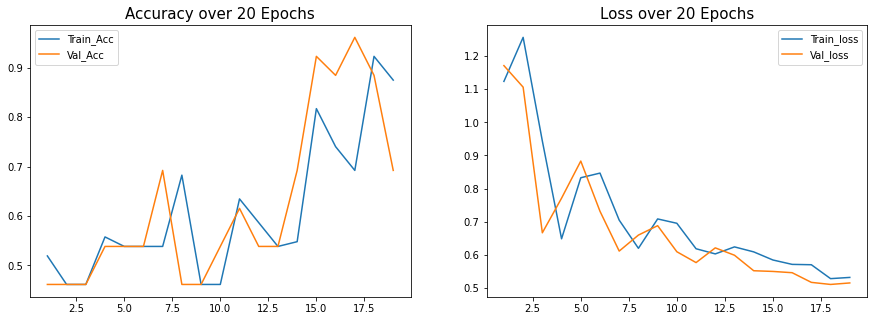

In [145]:
plot_history(history_res, 20)

18/18 [==============================] - 2s 127ms/step - loss: 0.5731 - acc: 0.7778
Test Loss:  0.5730676054954529
Test Accuracy:  0.7777777910232544
File:  covid/nejmoa2001191_f3-PA.jpeg


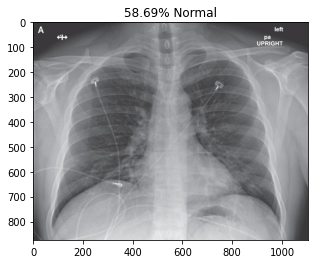

File:  covid/nejmoa2001191_f4.jpeg


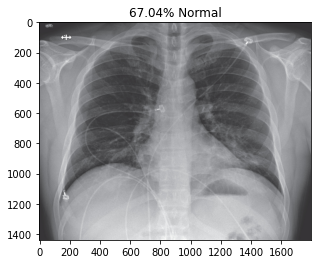

File:  covid/nejmoa2001191_f5-PA.jpeg


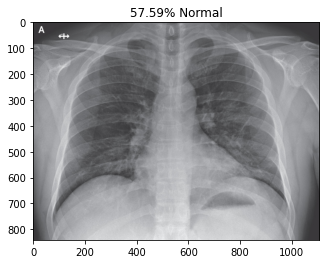

File:  covid/radiol.2020200490.fig3.jpeg


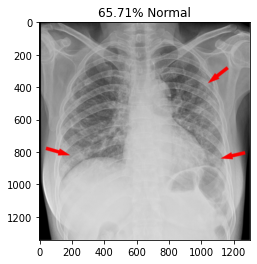

File:  covid/ryct.2020200028.fig1a.jpeg


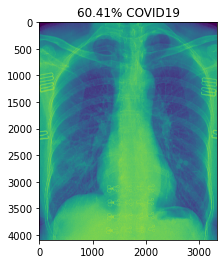

In [146]:
evaluate_model(res_model, test_data)

# Conclusion
 Transfer Learning is a very powerful tool in the arsenal of Deep learning as it allows to harnes the power of already trained deep nets and create model with very little data. The already trained models acts as feature extractors and then pass those features onto the dense layers to generate predictions.